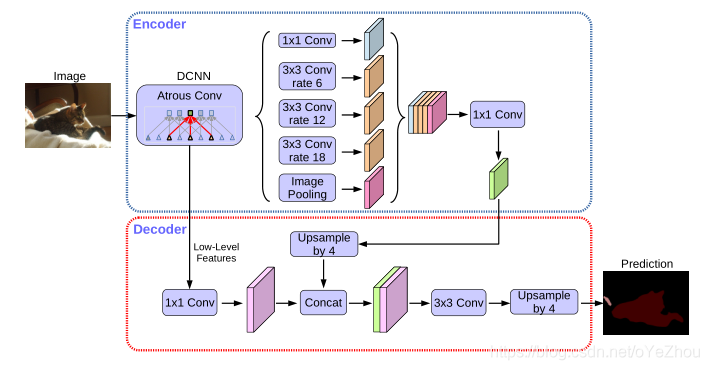

* 使用的是TEST2中的海冰数据集，RESNET50为主干网络,使用了另一种DECODER

In [2]:
import os,gc
import torch
import math
from PIL import Image
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.ToTensor()
])


path = './sea_ice'
result_path = './prediction\\'
target_size = (256,256)

* 数据读取方法

In [3]:
class MyDataset(Dataset):
    # TensorDataset继承Dataset, 重载了__init__, __getitem__, __len__
    # 实现将一组Tensor数据对封装成Tensor数据集
    # 能够通过index得到数据集的数据，能够通过len，得到数据集大小

    def __init__(self, path):
        self.name = os.listdir(os.path.join(path, 'label'))  #得到所有文件名
        self.path = path


    def __getitem__(self, index):
        segment_name = self.name[index]
        image_path = os.path.join(self.path, 'image', segment_name)
        label_path = os.path.join(self.path, 'label', segment_name)

        image  = Image.open(image_path)
        segment_image = Image.open(label_path)
        return transform(image), transform(segment_image)

    def __len__(self):
        return len(self.name)    # size(0) 返回当前张量维数的第一维


 #划分数据集   
def train_test_dataset(full_dataset, p):
    assert p > 0 and p < 1  
    train_size = int(p * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    return train_dataset, test_dataset

def plot_func(data,label):
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(Image.fromarray(np.uint8((data[i,:,:,0])*255)))# 数组转图像并显示
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):                                        #显示二值图像（标签）
        plt.subplot(2,8,i+1)
        plt.imshow((label[i,:,:,0]),cmap="gray")
    plt.show()

* 主干部分（mobilenetv2）

In [4]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1(inp, oup):
    return nn.Sequential(  
        #   进行3x3的逐层卷积，进行跨特征点的特征提取
        nn.Conv2d(input_channel_1, input_channel_1, 3, 1, groups=input_channel_1, bias=False),
        nn.BatchNorm2d(input_channel),
        nn.ReLU6(inplace=True),
        #   利用1x1卷积进行通道数的调整
        nn.Conv2d(input_channel, output_channel_1, 1, 1, 0, bias=False),
        nn.BatchNorm2d(output_channel_1),
        )


class InvertedResidual(nn.Module):                     #残差块（residual block） 若不使用残差边，则就是一个普通的三层卷积网络
    def __init__(self, inp, oup, stride):
        super(InvertedResidual, self).__init__()
        self.inp = inp
        self.oup = oup
        self.stride = stride                      #步长
        assert stride in [1, 2]                   # 限制步长
        hidden_dim = round(inp * 6)
        
        self.conv = nn.Sequential(
            #   利用1x1卷积进行通道数的上升（使网络具有更好的特征表现能力）
            nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            #   进行3x3的逐层卷积，进行跨特征点的特征提取
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            #   利用1x1卷积进行通道数的下降（降低运算量）
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup)
            )
        
    def forward(self, x):
        #是否使用残差边
        if self.stride == 1 and self.inp == self.oup:    #self.use_res_connect:
            return x + self.conv(x)  #若使用，则将输入值与特征提取结果相加（将低层特征与高层特征结合）
        else:
            return self.conv(x)      #若不使用，则返回特征提取结果

   
         # MobileNetV2类
    
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual

        
        assert input_size % 32 == 0            

        #features[0]                  先进行一次卷积   256, 256, 3 -> 128, 128, 32
        input_channel_0 = 3
        output_channel_0 = 32
        
        self.features = [nn.Sequential(                           
            nn.Conv2d(input_channel_0, output_channel_0, 3, 2, 1, bias=False),
            nn.BatchNorm2d(output_channel_0),
            nn.ReLU6(inplace=True)
            )]
        
     
        #features[1]                            128, 128, 32   ->  128, 128, 16  
        #做两次卷积，没有residual block
        input_channel_1  = output_channel_0
        output_channel_1 = int(16 * width_mult)
        self.features.append(nn.Sequential(
            #   进行3x3的逐层卷积，进行跨特征点的特征提取
            nn.Conv2d(input_channel_1, input_channel_1, 3, 1, groups=input_channel_1, bias=False),
            nn.BatchNorm2d(input_channel_1),
            nn.ReLU6(inplace=True),
            
            #   利用1x1卷积进行通道数的调整
            nn.Conv2d(input_channel_1, output_channel_1, 1, 1, 0, bias=False),
            nn.BatchNorm2d(output_channel_1),
            ))
 
        
        #features[2] - features[3]              128, 128, 16 -> 64, 64, 24
        #  t, c, n, s     [6, 24, 2, 2]     
        # t 是否进行升维（只有第一个残差块（residual block）不升 ）
        # c residual block输出维度
        # n 每个残差块中residual block的次数
        # s 是否进行长和宽的压缩（下采样）
        input_channel_2 = output_channel_1
        output_channel_2 = int(24 * width_mult)
        
        self.features.append(block(input_channel_2, output_channel_2, 2))
        self.features.append(block(output_channel_2, output_channel_2, 1))
        
        #features[4] - features[6]              64, 64, 24 -> 32， 32， 32
        #  t, c, n, s     [6, 32, 3, 2]     
        input_channel_3 = output_channel_2
        output_channel_3 = int(32 * width_mult)        

        self.features.append(block(input_channel_3, output_channel_3, 2))
        self.features.append(block(output_channel_3, output_channel_3, 1))
        self.features.append(block(output_channel_3, output_channel_3, 1))
        
        
        #features[7] - features[10]           32， 32， 32 -> 16, 16, 64
        #  t, c, n, s     [[6, 64, 4, 2]     
        input_channel_4 = output_channel_3
        output_channel_4 = int(64 * width_mult)        

        self.features.append(block(input_channel_4, output_channel_4, 2))
        self.features.append(block(output_channel_4, output_channel_4, 1))
        self.features.append(block(output_channel_4, output_channel_4, 1))        
        self.features.append(block(output_channel_4, output_channel_4, 1))
        
        
        #features[11] - features[13]          16, 16, 64 -》16, 16, 96
        #  t, c, n, s     [6, 96, 3, 1]    
        input_channel_5 = output_channel_4
        output_channel_5 = int(96 * width_mult)        

        self.features.append(block(input_channel_5, output_channel_5, 1))
        self.features.append(block(output_channel_5, output_channel_5, 1))
        self.features.append(block(output_channel_5, output_channel_5, 1))        
        
        
        
        
        #features[14] - features[16]  
        #  t, c, n, s     [6, 160, 3, 2]         16, 16, 96 ->8, 8,160
        input_channel_6 = output_channel_5
        output_channel_6 = int(160 * width_mult)         
        
        self.features.append(block(input_channel_6, output_channel_6, 2))
        self.features.append(block(output_channel_6, output_channel_6, 1))
        self.features.append(block(output_channel_6, output_channel_6, 1)) 
        

        
        #features[17]  
        #  t, c, n, s     [6, 320, 1, 1]         8, 8,160 -> 8,8, 320  
        input_channel_7 = output_channel_6
        output_channel_7 = int(320 * width_mult)         
        
        self.features.append(block(input_channel_7, output_channel_7, 1))

        
        self.features = nn.Sequential(*self.features)
        
    def forward(self, x):
        low_level_features = self.features[:4](x)      #得到浅层语义信息(共4层)         64, 64, 24
        x = self.features[4:](low_level_features)      #得到深层语义信息（共18层）      8,8, 320  
        return low_level_features, x         


      

In [5]:
import torch
import torchvision
import torch.nn as nn

class ResNet50(nn.Module):
    output_size = 2048
 
    def __init__(self, pretrained=True):
        super(ResNet50, self).__init__()
        pretrained = torchvision.models.resnet50(pretrained=True)
 
        for module_name in [
            "conv1",
            "bn1",
            "relu",
            "maxpool",
            "layer1",
            "layer2",
            "layer3",
            "layer4",
            "avgpool",
        ]:
            self.add_module(module_name, getattr(pretrained, module_name))
 
    def forward(self, x, get_ha=False):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        b1 = self.layer1(x)
        b2 = self.layer2(b1)
        b3 = self.layer3(b2)
        b4 = self.layer4(b3)
#         pool = self.avgpool(b4)
#         print(pool.size())
 
        if get_ha:
            return b1, b2, b3, b4, pool
        low_level_features = b1
        x = b4
        return low_level_features, x 

* 加强特征提取结构

In [6]:
#对上面得到的深层语义信息进行五个不同的卷积操作，得到五个不同的特征，并融合在一块
class ASPP(nn.Module):                        
    def __init__(self, dim_in, dim_out, rate=1, bn_mom=0.1):
        super(ASPP, self).__init__()
        self.branch1 = nn.Sequential(
                nn.Conv2d(dim_in, dim_out, 1, 1, padding=0, dilation=rate,bias=True),
                nn.BatchNorm2d(dim_out, momentum=bn_mom),
                nn.ReLU(inplace=True),
                )
        self.branch2 = nn.Sequential(
                nn.Conv2d(dim_in, dim_out, 3, 1, padding=6*rate, dilation=6*rate, bias=True),
                nn.BatchNorm2d(dim_out, momentum=bn_mom),
                nn.ReLU(inplace=True),
        )
        self.branch3 = nn.Sequential(
                nn.Conv2d(dim_in, dim_out, 3, 1, padding=12*rate, dilation=12*rate, bias=True),
                nn.BatchNorm2d(dim_out, momentum=bn_mom),
                nn.ReLU(inplace=True),
        )
        self.branch4 = nn.Sequential(
                nn.Conv2d(dim_in, dim_out, 3, 1, padding=18*rate, dilation=18*rate, bias=True),
                nn.BatchNorm2d(dim_out, momentum=bn_mom),
                nn.ReLU(inplace=True),
        )
        self.branch5_conv = nn.Conv2d(dim_in, dim_out, 1, 1, 0,bias=True)
        self.branch5_bn = nn.BatchNorm2d(dim_out, momentum=bn_mom)
        self.branch5_relu = nn.ReLU(inplace=True)

        self.conv_cat = nn.Sequential(
                nn.Conv2d(dim_out*5, dim_out, 1, 1, padding=0,bias=True),
                nn.BatchNorm2d(dim_out, momentum=bn_mom),
                nn.ReLU(inplace=True),		
        )

    def forward(self, x):
        [b, c, row, col] = x.size()
        #   一共五个分支 得到五个不同的特征
        conv1x1 = self.branch1(x)
        conv3x3_1 = self.branch2(x)
        conv3x3_2 = self.branch3(x)
        conv3x3_3 = self.branch4(x)

        #   第五个分支，全局平均池化+卷积

        global_feature = torch.mean(x,2,True)      #对通道求均值
        global_feature = torch.mean(global_feature,3,True)
        global_feature = self.branch5_conv(global_feature)
        global_feature = self.branch5_bn(global_feature)
        global_feature = self.branch5_relu(global_feature)
        global_feature = F.interpolate(global_feature, (row, col), None, 'bilinear', True)  #上采样，统一大小
        
   
        #   将五个分支的内容堆叠起来，然后1x1卷积整合特征

        feature_cat = torch.cat([conv1x1, conv3x3_1, conv3x3_2, conv3x3_3, global_feature], dim=1)
        result = self.conv_cat(feature_cat)
        return result


* decoder

In [7]:
class Decoder(nn.Module):
    def __init__(self, num_classes, backbone):
        super(Decoder, self).__init__()
        if backbone == 'ResNet50':
            low_level_inplanes = 256
        elif backbone == 'MobileNetV2':
            low_level_inplanes = 24
        else:
            raise NotImplementedError

        self.conv1 = nn.Conv2d(low_level_inplanes, 48, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU()
        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False), # 304  (2096 for delete aspp module)
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),  # 0.5
                                       nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), # decoder2
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),   # decoder2
                                       #nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       #BatchNorm(256),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), # decoder2
                                       nn.ReLU(),
                                       #nn.Conv2d(256, num_classes, kernel_size=1, stride=1))
                                       nn.Conv2d(64, num_classes, kernel_size=1, stride=1)) # decoder2
        #self._init_weight()


    def forward(self, x, low_level_feat):
        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)

        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_feat), dim=1)
        visual = x
        x = self.last_conv(x)
        #print('after decoder size:',x.size())

        return x

In [8]:
class DeepLab(nn.Module):
    def __init__(self, num_classes,backbone = "MobileNetV2"):
        super(DeepLab, self).__init__()
            #   获得两个特征层
            #   浅层特征    [64, 64, 24]
            #   主干部分    [8,8, 320]
        
        if backbone == "MobileNetV2":
            self.backbone = MobileNetV2()
            in_channels = 320
            low_level_channels = 24
        elif backbone == "ResNet50":
            self.backbone =  ResNet50()
            in_channels = 2048
            low_level_channels = 256       



        #   ASPP特征提取模块  利用不同膨胀率的膨胀卷积进行特征提取
        self.aspp = ASPP(dim_in=in_channels, dim_out=256)
        

        #   浅层特征边
        self.shortcut_conv = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.cat_conv = nn.Sequential(
            nn.Conv2d(48+256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Dropout(0.1),
        )
        self.cls_conv = nn.Conv2d(256, num_classes, 1, stride=1)
        decoder__ = Decoder(num_classes,backbone)
        self.decoder_ = decoder__ 

    def forward(self, x):
        H, W = x.size(2), x.size(3)
        #   获得两个特征层
        #   low_level_features: 浅层特征-进行卷积处理
        #   x : 主干部分-利用ASPP结构进行加强特征提取
        low_level_features, x = self.backbone(x)
        x = self.aspp(x)  #增强
        x = self.decoder_(x,low_level_features)
        
        
        
#         low_level_features = self.shortcut_conv(low_level_features)     
#         #   将加强特征边上采样
#         x = F.interpolate(x, size=(low_level_features.size(2), low_level_features.size(3)), mode='bilinear', align_corners=True)
#         #   与浅层特征堆叠后利用卷积进行特征提取
#         x = self.cat_conv(torch.cat((x, low_level_features), dim=1))
#         x = self.cls_conv(x)
#         #   上采样至原图大小
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        return x

* 精度计算

In [9]:
class Evaluator(object):
    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc
    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

def get_acc(label_true, label_predict, num_class = 3):
    evaluator = Evaluator(num_class)
    lab_p_ = torch.argmax(label_predict, dim=1)
    num = lab_p_.shape[0]
    for i in range(num):
        lab1= label_true[i,:,:]
        lab1[lab1>0.5] = 1
        lab1[lab1<=0.5] = 0
        
        lab_p = lab_p_[i,:,:]
        lab_t = torch.squeeze(lab1)
        lab_p = torch.squeeze(lab_p)
        lab_t = lab_t.long()
        lab_p = lab_p.long()
        evaluator.add_batch(lab_p.numpy(), lab_t.numpy())
    acc = evaluator.Pixel_Accuracy()
    return acc

In [12]:
if __name__ == "__main__":
    input_shape = [256, 256]
    data_path =r'./sea_ice'
    weight_path = os.path.join(data_path,'ResNet50_DeepLab_decoder.pth')
    img_data = MyDataset(data_path)
    num_classes = 2+1
    batch_size=4
    
    train_dataset, test_dataset = train_test_dataset(img_data, 0.8)
    trainloader = DataLoader(train_dataset, batch_size,shuffle=True)
    testloader = DataLoader(test_dataset, batch_size,shuffle=True)
    net = DeepLab(num_classes,"ResNet50")
    
    opt = optim.Adam(net.parameters())
    loss_fun = nn.CrossEntropyLoss()

    #定义两个数组
    Loss_list = []
    Accuracy_list = []
    Loss_list_val = []
    Accuracy_list_val = []
    
    for epoch in range(15):
        loss = 0
        accu = 0
        n = 0
        net.train()   # 将模型改为训练模式
        
        for step, (img, label) in enumerate(trainloader):
    
            out_image = net(img)
            train_loss = loss_fun(out_image, torch.squeeze(label.long()))
            opt.zero_grad()
            train_loss.backward()
            opt.step()
            acc = get_acc(label, out_image)  #记录分类正确的像元数比值
            
            loss += train_loss.item()         #记录每个样本的损失
            accu += acc                       #记录每个样本的精度
            if step % 5 == 0:
                print('Epoch: ', epoch, '| Step: ', step, '|loss:',train_loss.item(),"|acc:",acc)
            n+=1
        #记录批训练的损失和精度        
        Loss_list.append(loss / n)
        Accuracy_list.append(accu / n)        
        
        loss_ = 0
        accu_ = 0
        n = 0
        net.eval()   # 将模型改为测试模式
        for step, (img, label) in enumerate(testloader):
            out_image = net(img)
            train_loss = loss_fun(out_image, torch.squeeze(label.long()))
            acc = get_acc(label, out_image)  #记录分类正确的像元数比值
            loss_ += train_loss.item()         #记录每个样本的损失
            accu_ += acc                       #记录每个样本的精度
            if step % 5 == 0:
                print('  |val_loss:',train_loss.item(),"val_|acc:",acc)
            n+=1
        #记录损失和精度        
        Loss_list_val.append(loss_ /n)
        Accuracy_list_val.append(accu_ / n)

        
        
        
        
        
        if epoch % 3 == 0:                            #每20次更新权重文件
            torch.save(net.state_dict(), weight_path)   #保存权重
            print('save successfully!')
        epoch += 1    
        gc.collect()
        torch.cuda.empty_cache()
    torch.save(net.state_dict(), weight_path)   #保存权重
    print('save successfully!')



Epoch:  0 | Step:  0 |loss: 1.11476731300354 |acc: 0.2560310363769531
Epoch:  0 | Step:  5 |loss: 0.7784987688064575 |acc: 0.8545379638671875
Epoch:  0 | Step:  10 |loss: 0.9314549565315247 |acc: 0.4721641540527344
Epoch:  0 | Step:  15 |loss: 0.4549240469932556 |acc: 0.8163833618164062
Epoch:  0 | Step:  20 |loss: 0.5156468749046326 |acc: 0.68853759765625
Epoch:  0 | Step:  25 |loss: 0.46319296956062317 |acc: 0.7601852416992188
Epoch:  0 | Step:  30 |loss: 0.385114461183548 |acc: 0.8096122741699219
Epoch:  0 | Step:  35 |loss: 0.3305900990962982 |acc: 0.89208984375
  |val_loss: 0.42027515172958374 val_|acc: 0.79876708984375
  |val_loss: 0.35344868898391724 val_|acc: 0.840301513671875
save successfully!
Epoch:  1 | Step:  0 |loss: 0.4632194936275482 |acc: 0.7459640502929688
Epoch:  1 | Step:  5 |loss: 0.3157716989517212 |acc: 0.8084678649902344
Epoch:  1 | Step:  10 |loss: 0.3649642765522003 |acc: 0.7799263000488281
Epoch:  1 | Step:  15 |loss: 0.34037068486213684 |acc: 0.8040351867675

KeyboardInterrupt: 

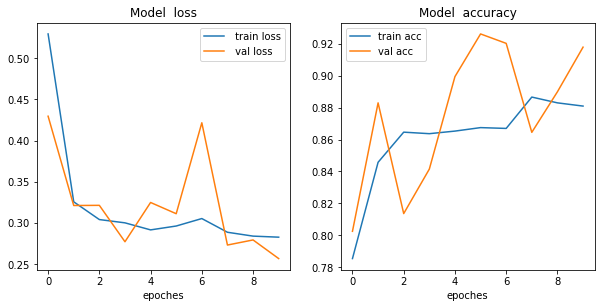

In [13]:
    fig=plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.plot(np.arange(len(Loss_list)), Loss_list,label=" train loss")
    plt.plot(np.arange(len(Loss_list_val)), Loss_list_val, label=" val loss")
    plt.legend() #显示图例
    plt.xlabel('epoches')
    #plt.ylabel("epoch")
    plt.title('Model  loss')

    plt.subplot(2,2,2)
    plt.plot(np.arange(len(Accuracy_list)), Accuracy_list,label= "train acc")
    plt.plot(np.arange(len(Accuracy_list_val)), Accuracy_list_val, label= "val acc")
    plt.legend() #显示图例
    plt.xlabel('epoches')
    #plt.ylabel("epoch")
    plt.title('Model  accuracy')
    plt.show()

